In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
from tensorflow import keras
from toai.imports import *

from data import DataContainer
from image import *
from image_learner import ImageLearner
from transformations import ImageParser, ImageCropTransformation, ImageRandomCropTransformation

In [3]:
DATA_DIR = Path('data/cactus')
TEMP_DIR = Path('temp/cactus')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
# !kaggle competitions download -c aerial-cactus-identification -p {str(DATA_DIR)}

In [49]:
df = pd.read_csv(DATA_DIR/'train.csv')
df = df[:10]

In [61]:
df.head(10)

,id,has_cactus,paths
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1,data/cactus/train/0004be2cfeaba1c0361d39e2b000...
1,000c8a36845c0208e833c79c1bffedd1.jpg,1,data/cactus/train/000c8a36845c0208e833c79c1bff...
2,000d1e9a533f62e55c289303b072733d.jpg,1,data/cactus/train/000d1e9a533f62e55c289303b072...
3,0011485b40695e9138e92d0b3fb55128.jpg,1,data/cactus/train/0011485b40695e9138e92d0b3fb5...
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1,data/cactus/train/0014d7a11e90b62848904c1418fc...
5,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1,data/cactus/train/0017c3c18ddd57a2ea6f9848c79d...
6,002134abf28af54575c18741b89dd2a4.jpg,0,data/cactus/train/002134abf28af54575c18741b89d...
7,0024320f43bdd490562246435af4f90b.jpg,0,data/cactus/train/0024320f43bdd490562246435af4...
8,002930423b9840e67e5a54afd4768a1e.jpg,1,data/cactus/train/002930423b9840e67e5a54afd476...
9,00351838ebf6dff6e53056e00a1e307c.jpg,1,data/cactus/train/00351838ebf6dff6e53056e00a1e...


In [51]:
df.describe()

,has_cactus
count,10.000000
mean,0.800000
std,0.421637
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
id            10 non-null object
has_cactus    10 non-null int64
dtypes: int64(1), object(1)
memory usage: 240.0+ bytes


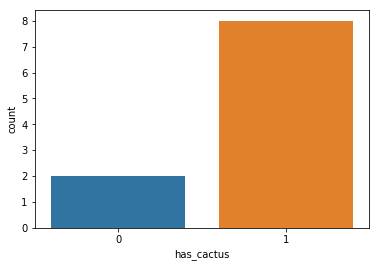

In [62]:
sns.countplot(x='has_cactus', data=df)

Data is somewhat unevenly distributed, but not a big issue.

In [63]:
IMG_DIMS = (224, 224, 3)
df['paths'] = df['id'].apply(lambda image_id: str(DATA_DIR/'train'/image_id))

In [64]:
train_data, validation_data = train_test_split(df, test_size=0.2)

In [65]:
test_data = pd.read_csv(DATA_DIR/'sample_submission.csv', low_memory=False)
test_data['paths'] = test_data['id'].apply(lambda image_id: str(DATA_DIR/'test'/image_id)) 

In [66]:
base_config = ImageDatasetConfig(
    img_dims=IMG_DIMS,
    parallel_calls=1,
    batch_size=16,
    prefetch=1,
    preprocess_pipeline=[
        ImageParser()
    ],
)

data_container = DataContainer(
    train=ImageDataset(base_config.copy(
        preprocess_pipeline=[
            ImageRandomCropTransformation(IMG_DIMS, crop_adjustment=1.6)
        ],
        shuffle=True,
    )).build_from_df(train_data, 'paths', 'has_cactus'),
    validation=ImageDataset(base_config.copy(
        preprocess_pipeline = [
            ImageCropTransformation(IMG_DIMS),
        ],
    )).build_from_df(validation_data, 'paths', 'has_cactus'),
    test=ImageDataset(base_config.copy(
        preprocess_pipeline=[
            ImageCropTransformation(IMG_DIMS)
        ],
    )).build_from_df(test_data, 'paths', 'has_cactus'),
)

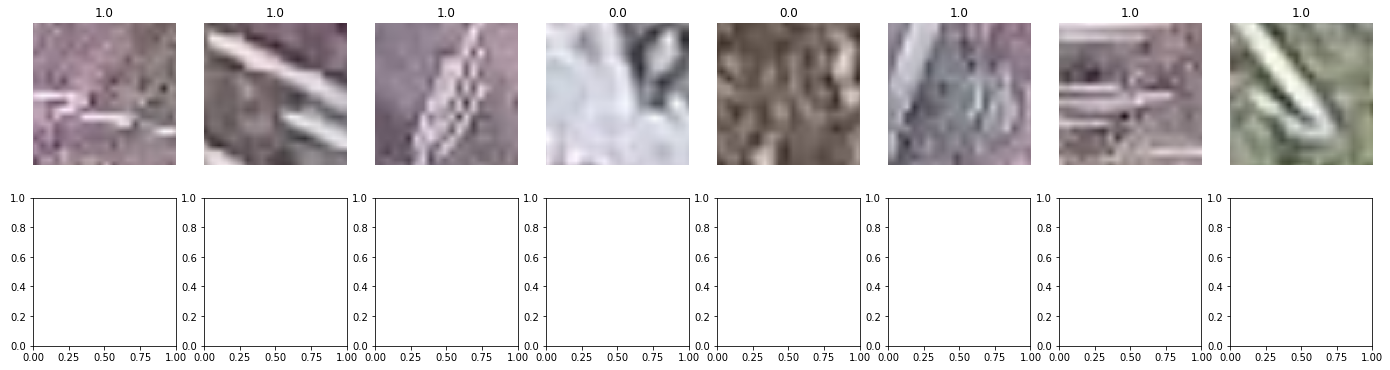

In [67]:
data_container.train.show()

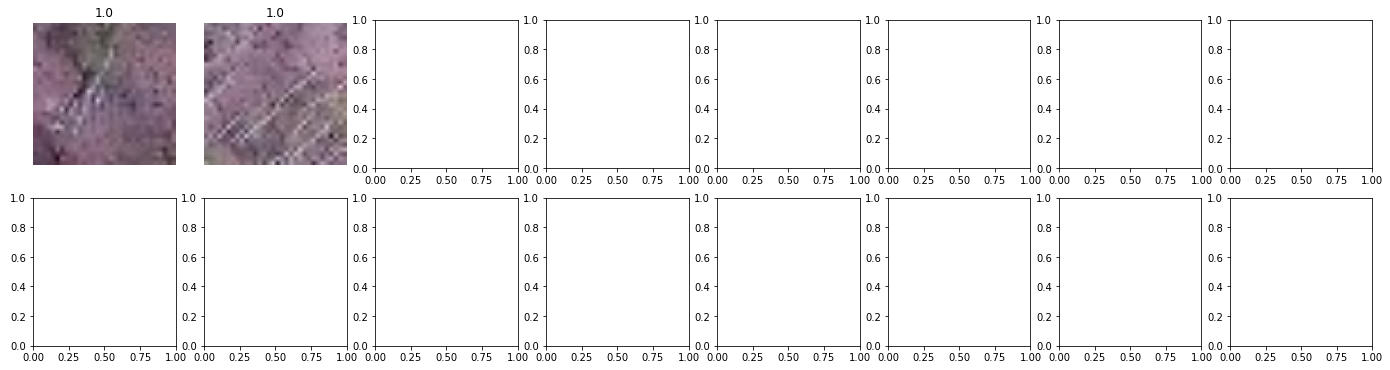

In [68]:
data_container.validation.show()

In [76]:
learner = ImageLearner(
    model_path=Path('xception'),
    data=data_container,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS
)

In [78]:
learner.auto_train(
    easing_epochs=2,
    epochs=1,
    optimizer=keras.optimizers.Adam,
    lr=1e-3,
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy]
)

Freezing all except last model layers
Training frozen model
Epoch 1/2
custom log 0
1/1 - 4s - loss: 0.8862 - binary_accuracy: 0.5000 - val_loss: 0.8301 - val_binary_accuracy: 0.5000
Epoch 2/2
custom log 1
1/1 - 1s - loss: 1.5357 - binary_accuracy: 0.5000 - val_loss: 0.7110 - val_binary_accuracy: 0.5000
Unfreezing all layers
Finished training frozen model
Starting model training


KeyboardInterrupt: 